### NYC Tree Census Data Cleaning

<div>
<br>
- Removal of unuseful columns<br>
- Renaming of column header<br>
- Removal of outliers in only continuous feature<br>
- Revaluing of two category columns(excluding NaN category) to binary values
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
## Import data from https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh
nyc_tree = pd.read_csv('data/2015_Street_Tree_Census_-_Tree_Data.csv')

In [3]:
nyc_tree.sample(7)

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
588182,83261,203096,07/21/2015,7,0,OnCurb,Alive,Good,Platanus x acerifolia,London planetree,...,3120800,New York,40.669112,-73.866057,1.021407e+06,183080.4869,42.0,1208.0,3098605.0,3.044650e+09
87433,237037,414804,09/19/2015,8,0,OnCurb,Alive,Good,Quercus acutissima,sawtooth oak,...,5012806,New York,40.559099,-74.114358,9.524737e+05,142992.2128,50.0,12806.0,5055599.0,5.040230e+09
504972,690865,314605,08/31/2016,12,0,OnCurb,Alive,Good,Acer saccharinum,silver maple,...,4102900,New York,40.781247,-73.804117,1.038498e+06,223966.8966,19.0,1029.0,4107672.0,4.047480e+09
536185,29496,345702,06/22/2015,14,0,OnCurb,Alive,Good,Acer rubrum,red maple,...,4063700,New York,40.711595,-73.861602,1.022618e+06,198560.1042,30.0,637.0,4094198.0,4.038510e+09
681971,180084,310221,08/27/2015,4,0,OnCurb,Alive,Good,Quercus palustris,pin oak,...,4013400,New York,40.704147,-73.833897,1.030304e+06,195859.8888,29.0,134.0,4192866.0,4.092330e+09
180039,362302,404503,10/22/2015,9,0,OffsetFromCurb,Alive,Good,Liquidambar styraciflua,sweetgum,...,5012500,New York,40.628853,-74.117654,9.515921e+05,168406.4333,49.0,125.0,5005933.0,5.002200e+09
224962,424589,320186,11/04/2015,4,0,OnCurb,Alive,Good,Quercus palustris,pin oak,...,4140902,New York,40.746164,-73.782213,1.044596e+06,211199.3818,20.0,140902.0,4128012.0,4.056660e+09


In [4]:
nyc_tree.columns

Index(['tree_id', 'block_id', 'created_at', 'tree_dbh', 'stump_diam',
       'curb_loc', 'status', 'health', 'spc_latin', 'spc_common', 'steward',
       'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
       'brch_light', 'brch_shoe', 'brch_other', 'address', 'postcode',
       'zip_city', 'community board', 'borocode', 'borough', 'cncldist',
       'st_assem', 'st_senate', 'nta', 'nta_name', 'boro_ct', 'state',
       'latitude', 'longitude', 'x_sp', 'y_sp', 'council district',
       'census tract', 'bin', 'bbl'],
      dtype='object')

In [5]:
## Reorder columns making target variable 'health' the first
column_headers = list(nyc_tree.columns)
column_headers = [column_headers[7]] + column_headers[:7] + column_headers[8:]
nyc_tree = nyc_tree[column_headers]

In [6]:
nyc_tree_eda = nyc_tree
nyc_tree_eda.to_csv('data/nyc_tree_eda.csv', index=False)

In [7]:
def two_category_binarizer(desirable_option, series):
    nyc_tree[series] = nyc_tree[series].apply(lambda x: None if pd.isnull(x)==True else (1 if x==desirable_option else 0))

#### Column 2 of 45<br>&emsp;tree_id

In [8]:
len(nyc_tree[nyc_tree.duplicated(subset='tree_id', keep=False)]) == 0

True

In [9]:
## After determining there are no duplicated tree ids this column is no longer necessary
nyc_tree.drop('tree_id', axis=1, inplace=True)

#### Column 3 of 45<br>&emsp;block_id

In [10]:
## Drop block_id for now; too many unique values

In [11]:
nyc_tree.drop('block_id', axis=1, inplace=True)

#### Column 4 of 45<br>&emsp;created_at

In [12]:
nyc_tree.drop('created_at', axis=1, inplace=True)

#### Column 5 of 45<br>&emsp;tree_dbh

In [13]:
nyc_tree.tree_dbh.value_counts(dropna=False)

4      60372
3      54454
2      41977
5      41642
11     37978
       ...  
75         1
151        1
154        1
159        1
450        1
Name: tree_dbh, Length: 146, dtype: int64

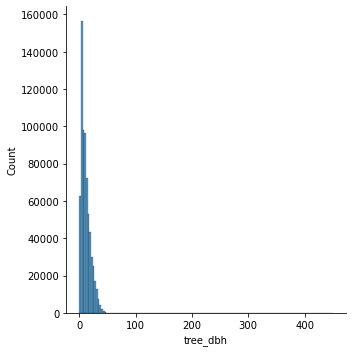

In [14]:
sns.displot(nyc_tree.tree_dbh, bins=150);

In [15]:
nyc_tree.loc[nyc_tree.status == 'Alive'].tree_dbh.describe()

count    652173.000000
mean         11.709485
std           8.634239
min           0.000000
25%           5.000000
50%          10.000000
75%          16.000000
max         425.000000
Name: tree_dbh, dtype: float64

In [16]:
## Initialize 25th and 75th percentiles and the interquartile range for living trees
svnty_fv_per = np.percentile(nyc_tree.loc[nyc_tree.status == 'Alive'].tree_dbh, 75)
twnty_fv_per = np.percentile(nyc_tree.loc[nyc_tree.status == 'Alive'].tree_dbh, 25)
alive_tree_diameter_iqr = svnty_fv_per - twnty_fv_per

In [17]:
## After brief research some tree diameters seem too large, remove outliers of living trees
nyc_tree.drop(nyc_tree.loc[nyc_tree.status == 'Alive'].loc[(nyc_tree.tree_dbh < (twnty_fv_per - 1.5*alive_tree_diameter_iqr))
                                    | (nyc_tree.tree_dbh > (svnty_fv_per + 1.5*alive_tree_diameter_iqr))].index, inplace=True)

In [18]:
nyc_tree.loc[nyc_tree.status == 'Alive'].tree_dbh.describe()

count    636794.000000
mean         11.080827
std           7.501970
min           0.000000
25%           5.000000
50%          10.000000
75%          16.000000
max          32.000000
Name: tree_dbh, dtype: float64

#### Column 6 of 45<br>&emsp;stump_diam

In [19]:
nyc_tree.loc[nyc_tree.stump_diam > 0].shape

(17654, 42)

In [20]:
nyc_tree.status.value_counts(dropna=False)

Alive    636794
Stump     17654
Dead      13961
Name: status, dtype: int64

In [21]:
nyc_tree.health.value_counts(dropna=False)

Good    514974
Fair     95200
NaN      31616
Poor     26619
Name: health, dtype: int64

In [22]:
## Drop 'stump_diam' column now and stumps later when addressing status column
nyc_tree.drop('stump_diam', axis=1, inplace=True)

#### Column 7 of 45<br>&emsp;curb_loc

In [23]:
nyc_tree.curb_loc.value_counts(dropna=False)

OnCurb            642475
OffsetFromCurb     25934
Name: curb_loc, dtype: int64

In [24]:
## Rename 'curb_loc' 'on_curb'.  Replace 'OnCurb' values with 1,
## replace 'OffsetFromCurb' values with 0, and ignore missing values
nyc_tree.rename({'curb_loc': 'on_curb'}, axis=1, inplace=True)
two_category_binarizer('OnCurb', 'on_curb')

#### Column 8 of 45<br>&emsp;status

In [25]:
nyc_tree.status.value_counts()

Alive    636794
Stump     17654
Dead      13961
Name: status, dtype: int64

In [26]:
## Restrict data to only living trees
nyc_tree.drop(nyc_tree.loc[nyc_tree.status != 'Alive'].index, inplace=True)

In [27]:
nyc_tree.shape

(636794, 41)

In [28]:
## Address one row still missing value for health
nyc_tree.drop(nyc_tree.loc[nyc_tree.health.isna() == True].index, inplace=True)

In [29]:
nyc_tree.drop('status', axis=1, inplace=True)

<div class="alert alert-block alert-info">
Column 9 of 45<br>&emsp;spc_latin needs adjusting
</div>

In [30]:
nyc_tree.spc_latin.value_counts(dropna=False)

Platanus x acerifolia                 79028
Gleditsia triacanthos var. inermis    64210
Pyrus calleryana                      58896
Quercus palustris                     50041
Acer platanoides                      34032
                                      ...  
Pinus rigida                             33
Maclura pomifera                         29
Pinus sylvestris                         25
Pinus virginiana                         10
NaN                                       4
Name: spc_latin, Length: 133, dtype: int64

In [31]:
## Temporarily drop 'spc_latin' column
nyc_tree.drop('spc_latin', axis=1, inplace=True)

#### Column 10 of 45<br>&emsp;spc_common

In [32]:
nyc_tree.spc_common.value_counts(dropna=False)

London planetree    79028
honeylocust         64210
Callery pear        58896
pin oak             50041
Norway maple        34032
                    ...  
pitch pine             33
Osage-orange           29
Scots pine             25
Virginia pine          10
NaN                     4
Name: spc_common, Length: 133, dtype: int64

In [33]:
## No need for both 'spc_latin' and 'spc_common'
nyc_tree.drop('spc_common', axis=1, inplace=True)

#### Column 11 of 45<br>&emsp;steward

In [34]:
nyc_tree.steward.value_counts(dropna=False)

None       473821
1or2       142314
3or4        19061
4orMore      1597
Name: steward, dtype: int64

In [35]:
for value in nyc_tree.steward.value_counts(dropna=False).index:
    print(value)
    print(nyc_tree.loc[nyc_tree.steward == value].health.value_counts(normalize=True, dropna=False))

None
Good    0.810179
Fair    0.148560
Poor    0.041260
Name: health, dtype: float64
1or2
Good    0.802823
Fair    0.153084
Poor    0.044093
Name: health, dtype: float64
3or4
Good    0.812707
Fair    0.148156
Poor    0.039138
Name: health, dtype: float64
4orMore
Good    0.845335
Fair    0.124609
Poor    0.030056
Name: health, dtype: float64


#### Column 12 of 45<br>&emsp;guards

In [36]:
nyc_tree.guards.value_counts(dropna=False)

None       557419
Helpful     51568
Harmful     20140
Unsure       7665
NaN             1
Name: guards, dtype: int64

#### Column 13 of 45<br>&emsp;sidewalk

In [37]:
nyc_tree.sidewalk.value_counts(dropna=False)

NoDamage    457121
Damage      179671
NaN              1
Name: sidewalk, dtype: int64

In [38]:
## Replace 'NoDamage' values with 1, replace 'Damage' values with 0, and ignore missing values
two_category_binarizer('NoDamage', 'sidewalk')

#### Column 14 of 45<br>&emsp;user_type

In [39]:
## This data does not seem to have a relationship with the target variable
nyc_tree.drop('user_type', axis=1, inplace=True)

#### Column 15 of 45<br>&emsp;problems

In [40]:
nyc_tree.problems.value_counts(dropna=False)

None                                                        420414
Stones                                                       90458
BranchLights                                                 28825
Stones,BranchLights                                          16525
RootOther                                                    11155
                                                             ...  
RootOther,WiresRope,TrunkLights,BranchLights,BranchOther         1
Stones,BranchLights,Sneakers,BranchOther                         1
MetalGrates,RootOther,TrunkLights,BranchLights                   1
Stones,RootOther,TrunkLights,BranchLights,BranchOther            1
MetalGrates,RootOther,WiresRope                                  1
Name: problems, Length: 232, dtype: int64

In [41]:
## Drop 'problems' column as it is a summary of the following nine columns
nyc_tree.drop('problems', axis=1, inplace=True)

#### Column 16 of 45<br>&emsp;root_stone

In [42]:
nyc_tree.root_stone.value_counts(dropna=False)

No     504544
Yes    132249
Name: root_stone, dtype: int64

In [43]:
## Replace 'No' values with 1 and replace 'Yes' values with 0
two_category_binarizer('No', 'root_stone')

#### Column 17 of 45<br>&emsp;root_grate

In [44]:
nyc_tree.root_grate.value_counts(dropna=False)

No     633268
Yes      3525
Name: root_grate, dtype: int64

In [45]:
## Replace 'No' values with 1 and replace 'Yes' values with 0
two_category_binarizer('No', 'root_grate')

#### Column 18 of 45<br>&emsp;root_other

In [46]:
nyc_tree.root_other.value_counts(dropna=False)

No     607514
Yes     29279
Name: root_other, dtype: int64

In [47]:
## Replace 'No' values with 1 and replace 'Yes' values with 0
two_category_binarizer('No', 'root_other')

#### Column 19 of 45<br>&emsp;trunk_wire

In [48]:
nyc_tree.trunk_wire.value_counts(dropna=False)

No     624207
Yes     12586
Name: trunk_wire, dtype: int64

In [49]:
## Replace 'No' values with 1 and replace 'Yes' values with 0
nyc_tree.rename({'trunk_wire': 'trnk_wire'}, axis=1, inplace=True)
two_category_binarizer('No', 'trnk_wire')

#### Column 20 of 45<br>&emsp;trnk_light

In [50]:
nyc_tree.trnk_light.value_counts(dropna=False)

No     635772
Yes      1021
Name: trnk_light, dtype: int64

In [51]:
## Replace 'No' values with 1 and replace 'Yes' values with 0
two_category_binarizer('No', 'trnk_light')

#### Column 21 of 45<br>&emsp;trnk_other

In [52]:
nyc_tree.trnk_other.value_counts(dropna=False)

No     605165
Yes     31628
Name: trnk_other, dtype: int64

In [53]:
## Replace 'No' values with 1 and replace 'Yes' values with 0
two_category_binarizer('No', 'trnk_other')

#### Column 22 of 45<br>&emsp;brch_light

In [54]:
nyc_tree.brch_light.value_counts(dropna=False)

No     577178
Yes     59615
Name: brch_light, dtype: int64

In [55]:
## Replace 'No' values with 1 and replace 'Yes' values with 0
two_category_binarizer('No', 'brch_light')

#### Column 23 of 45<br>&emsp;brch_shoe

In [56]:
nyc_tree.brch_shoe.value_counts(dropna=False)

No     636387
Yes       406
Name: brch_shoe, dtype: int64

In [57]:
## Replace 'No' values with 1 and replace 'Yes' values with 0
two_category_binarizer('No', 'brch_shoe')

#### Column 24 of 45<br>&emsp;brch_other

In [58]:
nyc_tree.brch_other.value_counts(dropna=False)

No     612844
Yes     23949
Name: brch_other, dtype: int64

In [59]:
## Replace 'No' values with 1 and replace 'Yes' values with 0
two_category_binarizer('No', 'brch_other')

#### Column 25 of 45<br>&emsp;address

In [60]:
nyc_tree.address.value_counts(dropna=False)

106 CROSS BAY BOULEVARD    210
2350 FOREST HILL ROAD      130
2 TELEPORT DRIVE           124
900 SOUTH AVENUE            88
2750 VETERANS ROAD WEST     78
                          ... 
30-014 70 STREET             1
2071 CROTONA AVENUE          1
1266 FLATBUSH AVENUE         1
223 WHITMAN DRIVE            1
696 WILLOUGHBY AVENUE        1
Name: address, Length: 385952, dtype: int64

In [61]:
## Unable to use this data in modeling
nyc_tree.drop('address', axis=1, inplace=True)

#### Column 26 of 45<br>&emsp;postcode

In [62]:
nyc_tree.postcode.value_counts(dropna=False)

10312    21241
10314    16060
10309    12070
10306    11996
11234    10537
         ...  
11697       24
10048       11
11451        9
11096        9
10115        7
Name: postcode, Length: 191, dtype: int64

In [63]:
## Unable to use this data in modeling
nyc_tree.drop('postcode', axis=1, inplace=True)

#### Column 27 of 45<br>&emsp;zip_city

In [64]:
## Seems to be a combination of boroughs and neighborhoods, not useful
nyc_tree.drop('zip_city', axis=1, inplace=True)

#### Column 28 of 45<br>&emsp;community board

In [65]:
## Unable to use this data in modeling
nyc_tree.drop('community board', axis=1, inplace=True)

#### Column 29 of 45<br>&emsp;borocode

In [66]:
## Provides same information as 'borough'
nyc_tree.drop('borocode', axis=1, inplace=True)

#### Column 30 of 45<br>&emsp;borough

In [67]:
nyc_tree.borough.value_counts(dropna=False)

Queens           229714
Brooklyn         165967
Staten Island     99330
Bronx             79555
Manhattan         62227
Name: borough, dtype: int64

In [68]:
nyc_tree.health = nyc_tree.health.apply(lambda x: 2 if x=='Good' else (1 if x=='Fair' else 0))

In [69]:
nyc_tree_cleaned = nyc_tree.iloc[:, :16]

In [70]:
nyc_tree_cleaned.to_csv('data/nyc_tree_cleaned.csv', index=False)